Preprocessing

In [ ]:
# loading the capstone dataset folder from my drive and printing the files under it

import os

dataset_path = '/content/drive/My Drive/Capstone/B2C'
# os.listdir(dataset_path)  # List files in the dataset folder


## Steps for preprocessing

Calculate the sum of taxable_value for the sales data and the sum of deposit_amount for the bank data.

Merge the two aggregated DataFrames on the company_id.

Create the discrepancy column by subtracting the total deposit_amount from the total taxable_value for each company.


In [ ]:
# Getting the deposit amount for the B2C sales for each company from the Bank Statements


import pandas as pd
import os
from google.colab import drive


bank_statements_folder = '/content/drive/My Drive/Capstone/B2C/bank_statements1_preprocessed'
# IMPORTANT: Update this path to your B2C Sales folder
b2c_sales_folder = '/content/drive/My Drive/Capstone/B2C/b2c_sales_fraud_cleaned'


# Processing Bank Statements
bank_data_list = []
print(f"Processing files in: {bank_statements_folder}")
try:
    for filename in os.listdir(bank_statements_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(bank_statements_folder, filename)
            company_id = filename.split('_')[0]
            try:
                df = pd.read_csv(file_path)
                b2c_transactions = df[~df['Narration'].astype(str).str.contains('(B2B)', regex=False)]
                total_b2c_deposit = b2c_transactions['Deposit Amt.'].sum()
                bank_data_list.append({'company_id': company_id, 'Deposit Amount': total_b2c_deposit})
            except Exception as e:
                print(f"Could not process bank file {filename}. Error: {e}")
except FileNotFoundError:
    print(f"Error: The folder path '{bank_statements_folder}' was not found.")

deposits_df = pd.DataFrame(bank_data_list)


# Processing B2C Sales Files
sales_data_list = []
print(f"\nProcessing files in: {b2c_sales_folder}")
try:
    for filename in os.listdir(b2c_sales_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(b2c_sales_folder, filename)
            company_id = filename.split('_')[0]
            try:
                df = pd.read_csv(file_path)
                total_taxable_value = df['Taxable Value'].sum()
                sales_data_list.append({'company_id': company_id, 'Taxable Value': total_taxable_value})
            except Exception as e:
                print(f"Could not process sales file {filename}. Error: {e}")
except FileNotFoundError:
    print(f"Error: The folder path '{b2c_sales_folder}' was not found.")

taxable_value_df = pd.DataFrame(sales_data_list)


# Finalization: Merge Datasets and Save
if not deposits_df.empty and not taxable_value_df.empty:
    final_dataset = pd.merge(deposits_df, taxable_value_df, on='company_id', how='outer')

    # Handle missing values after merge
    # If a company is in one dataset but not the other, fill the missing value with 0.
    final_dataset['Taxable Value'] = final_dataset['Taxable Value'].fillna(0)
    final_dataset['Deposit Amount'] = final_dataset['Deposit Amount'].fillna(0)

    # Calculate the Discrepancy column
    final_dataset['Discrepancy'] = final_dataset['Deposit Amount'] - final_dataset['Taxable Value']

    # Round tiny floating point discrepancies to zero
    # Any discrepancy with an absolute value less than 1e-6 will be set to 0.
    final_dataset.loc[final_dataset['Discrepancy'].abs() < 1e-6, 'Discrepancy'] = 0

    print("\n--- Combined B2C Dataset ---")
    print(final_dataset.head())

    # Save your new dataset to a CSV file
    output_path = '/content/drive/My Drive/Capstone/B2C/b2c_preprocessed1.csv'
    final_dataset.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")

else:
    print("\nCould not create final dataset. One or both of the source folders were empty or could not be processed.")

Processing files in: /content/drive/My Drive/Capstone/B2C/bank_statements1_preprocessed

Processing files in: /content/drive/My Drive/Capstone/B2C/b2c_sales_fraud_cleaned

--- Combined B2C Dataset ---
  company_id  Deposit Amount  Taxable Value   Discrepancy
0      0L725    2.979173e+08   2.979173e+08  0.000000e+00
1      0LVSN    2.364695e+08   2.364695e+08  0.000000e+00
2      0Y9DO    2.670551e+08   2.670551e+08  0.000000e+00
3      1IBLJ    2.488660e+08   2.488660e+08  0.000000e+00
4      1T2TA    4.178090e+08   0.000000e+00  4.178090e+08

Dataset saved to: /content/drive/My Drive/Capstone/B2C/b2c_preprocessed1.csv


Load the dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

df = pd.read_csv('/content/drive/MyDrive/Capstone/B2C/b2c_preprocessed.csv')

Safe ratio calculation (Deposit/Taxable):
Creates a ratio to detect mismatches, replacing 0 to avoid division errors.


If deposits are much higher than taxable, it could indicate under-reporting.

If taxable is zero, but deposits are large, the ratio → ∞ (infinite), which breaks the model.

In [ ]:
# Safe ratio calculation
min_positive_taxable = df.loc[df['Taxable Value'] > 0, 'Taxable Value'].min()
adjusted_taxable = df['Taxable Value'].apply(lambda x: x if x > 0 else min_positive_taxable)
df['Ratio'] = df['Deposit Amount'] / adjusted_taxable

Feature engineering and selection

In [ ]:
# Feature engineering
df['Log_Deposit'] = np.log1p(df['Deposit Amount'])
df['Log_Taxable'] = np.log1p(df['Taxable Value'])
df['Log_Discrepancy'] = np.log1p(df['Discrepancy'])
df['Discrepancy_to_Deposit'] = np.where(
    df['Deposit Amount'] > 0,
    df['Discrepancy'] / df['Deposit Amount'],
    0
)

# Select features for Isolation Forest
features = df[[
    'Deposit Amount', 'Taxable Value', 'Discrepancy', 'Ratio',
    'Log_Deposit', 'Log_Taxable', 'Log_Discrepancy', 'Discrepancy_to_Deposit'
]]

IsolationForest is tree-based so scaling is not strictly required, but scaling helps PCA (next step). Good to fit scaler on training data only when in production.

PCA - Principal Component Analysis

Reduce dimensionality and noise before IsolationForest.

In [ ]:
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=4, random_state=42)
features_pca = pca.fit_transform(features_scaled)

Isolation Forest training  - For fraud/financial underreporting, contamination is often set to 1–5% (0.01–0.05)


In [ ]:
# Isolation Forest model
model = IsolationForest(
    contamination=0.07,
    random_state=42,
    n_estimators=200,
    max_samples='auto',
    max_features=4,
    bootstrap=True
)
model.fit(features_pca)


IsolationForest(bootstrap=True, contamination=0.07, max_features=4,
                n_estimators=200, random_state=42)

In [ ]:
# GETTING THE GROUND TRUTH

# Predict anomalies
df['anomaly'] = model.predict(features_pca)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

# Business rules
rule1 = (df['Taxable Value'] == 0) & (df['Deposit Amount'] > 1e7)
rule2 = (df['Deposit Amount'] > 0) & (df['Discrepancy'] / df['Deposit Amount'] > 0.1)

# Hybrid underreporting flag
df['underreport_flag'] = rule1 | rule2 | (df['anomaly'] == 1)

# ---- Use underreporting flag as TRUE LABEL ----
df['true_label'] = df['underreport_flag'].astype(int)

# ----- Evaluate Isolation Forest against hybrid/business rules ground truth -----
y_true = df['true_label']         # "ground truth" from hybrid flag
y_pred = df['anomaly']            # Isolation Forest prediction

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print("\nIsolation Forest Detection vs. Hybrid Flag Ground Truth:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Review flagged companies
underreporting_cases = df[df['underreport_flag']].sort_values(by='Discrepancy', ascending=False)
print("Underreporting companies detected (hybrid approach):")
print(underreporting_cases[['company_id', 'Deposit Amount', 'Taxable Value', 'Discrepancy',
                            'Discrepancy_to_Deposit', 'anomaly', 'underreport_flag']])

# Save all results
output_path = '/content/drive/MyDrive/Capstone Preprocessing/B2C/b2c_underreporting_results_with_eval.csv'
df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")



Isolation Forest Detection vs. Hybrid Flag Ground Truth:
Accuracy: 0.9900
Precision: 1.0000
Recall: 0.8750
F1 Score: 0.9333
Underreporting companies detected (hybrid approach):
   company_id  Deposit Amount  Taxable Value   Discrepancy  \
4       1T2TA    4.178090e+08   0.000000e+00  4.178090e+08   
24      6WKTA    3.814998e+08   0.000000e+00  3.814998e+08   
86      VG0FN    2.852121e+08   0.000000e+00  2.852121e+08   
90      XAJI0    3.574425e+08   1.875134e+08  1.699291e+08   
85      UJZA7    3.724898e+08   2.544193e+08  1.180705e+08   
17      5OWF7    2.517539e+08   1.391563e+08  1.125977e+08   
75      PHR62    3.325899e+08   2.246818e+08  1.079081e+08   
98      ZKLOO    1.016885e+08   8.016318e+07  2.152528e+07   

    Discrepancy_to_Deposit  anomaly  underreport_flag  
4                 1.000000        1              True  
24                1.000000        1              True  
86                1.000000        1              True  
90                0.475403        1    

PR CURVE


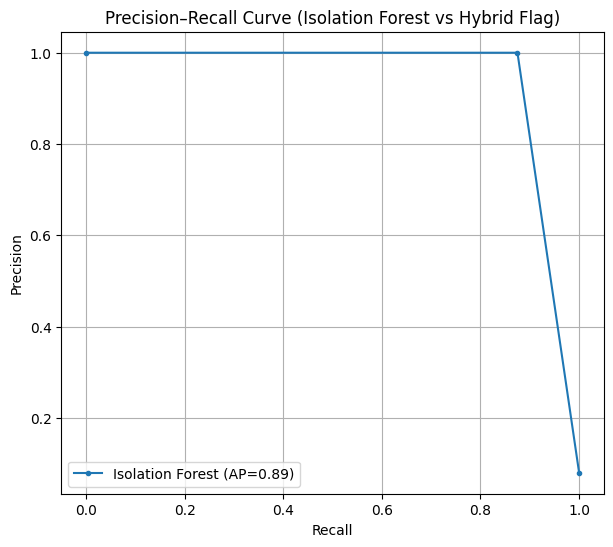

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ----- Precision-Recall Curve -----
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, df['anomaly'])
avg_precision = average_precision_score(y_true, df['anomaly'])

plt.figure(figsize=(7, 6))
plt.plot(recall_vals, precision_vals, marker='.', label=f'Isolation Forest (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Isolation Forest vs Hybrid Flag)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone Preprocessing/B2C/Model/Other models/b2c_preprocessed.csv')

# Feature engineering
min_positive_taxable = df.loc[df['Taxable Value'] > 0, 'Taxable Value'].min()
adjusted_taxable = df['Taxable Value'].apply(lambda x: x if x > 0 else min_positive_taxable)
df['Ratio'] = df['Deposit Amount'] / adjusted_taxable
df['Log_Deposit'] = np.log1p(df['Deposit Amount'])
df['Log_Taxable'] = np.log1p(df['Taxable Value'])
df['Log_Discrepancy'] = np.log1p(df['Discrepancy'])
df['Discrepancy_to_Deposit'] = np.where(
    df['Deposit Amount'] > 0, df['Discrepancy'] / df['Deposit Amount'], 0
)

features = df[[
    'Deposit Amount', 'Taxable Value', 'Discrepancy', 'Ratio',
    'Log_Deposit', 'Log_Taxable', 'Log_Discrepancy', 'Discrepancy_to_Deposit'
]]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=4, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# Business rule flags for hybrid
rule1 = (df['Taxable Value'] == 0) & (df['Deposit Amount'] > 1e7)
rule2 = (df['Deposit Amount'] > 0) & (df['Discrepancy'] / df['Deposit Amount'] > 0.1)
df['underreport_flag'] = rule1 | rule2

# Use hybrid flag as ground truth
df['true_label'] = df['underreport_flag'].astype(int)

X = features_pca

results = []


# 1. One-Class SVM


In [ ]:
svm = OneClassSVM(nu=0.03, kernel='rbf', gamma='auto')  # nu similar to contamination
svm.fit(X)
pred_svm = np.where(svm.predict(X) == -1, 1, 0)
acc_svm = accuracy_score(df['true_label'], pred_svm)
prec_svm = precision_score(df['true_label'], pred_svm, zero_division=0)
f1_svm = f1_score(df['true_label'], pred_svm, zero_division=0)
results.append(['OneClassSVM', acc_svm, prec_svm, f1_svm])


# 2. Local Outlier Factor

In [ ]:

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
pred_lof = np.where(lof.fit_predict(X) == -1, 1, 0)
acc_lof = accuracy_score(df['true_label'], pred_lof)
prec_lof = precision_score(df['true_label'], pred_lof, zero_division=0)
f1_lof = f1_score(df['true_label'], pred_lof, zero_division=0)
results.append(['LocalOutlierFactor', acc_lof, prec_lof, f1_lof])


# 3. Elliptic Envelope (robust to elliptical Gaussian outliers)

In [ ]:

ell = EllipticEnvelope(contamination=0.03, random_state=42)
ell.fit(X)
pred_ell = np.where(ell.predict(X) == -1, 1, 0)
acc_ell = accuracy_score(df['true_label'], pred_ell)
prec_ell = precision_score(df['true_label'], pred_ell, zero_division=0)
f1_ell = f1_score(df['true_label'], pred_ell, zero_division=0)
results.append(['EllipticEnvelope', acc_ell, prec_ell, f1_ell])


# Results table

In [ ]:

# Results table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'F1'])
print(results_df)


                Model  Accuracy  Precision        F1
0         OneClassSVM      0.86       0.25  0.300000
1  LocalOutlierFactor      0.95       1.00  0.545455
2    EllipticEnvelope      0.95       1.00  0.545455


#K fold


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings('ignore')

# 1. Setup Data and Features
feature_cols = [
    'Deposit Amount', 'Taxable Value', 'Discrepancy', 'Log_Deposit',
    'Log_Taxable', 'Log_Discrepancy', 'Discrepancy_to_Deposit'
]

# Ensure no NaNs or Infinite values
X = df[feature_cols].fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# The target is the 'true_label' generated in previous steps
y = df['true_label']

# 2. Define Models
contamination_rate = 0.08

models = {
    "IsolationForest": IsolationForest(
        contamination=contamination_rate,
        n_estimators=200,
        random_state=42
    ),
    "OneClassSVM": OneClassSVM(
        nu=contamination_rate,
        kernel="rbf",
        gamma='scale'
    ),
    "EllipticEnvelope": EllipticEnvelope(
        contamination=contamination_rate,
        support_fraction=0.9,
        random_state=42
    ),
    "LocalOutlierFactor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=contamination_rate,
        novelty=True  # Crucial for prediction on new data (folds)
    )
}

# 3. Initialize K-Fold
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Dictionary to store final summary data
final_summary = []

print(f"Starting {k}-Fold Cross-Validation on {len(models)} models...")

# 4. Loop through Models
for model_name, model in models.items():
    print(f"\nEvaluating Model: {model_name}")
    print("="*40)

    fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    fold_idx = 1

    # Inner Loop: Folds
    for train_index, test_index in skf.split(X, y):
        # A. Split Data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # B. Preprocessing (Standardization)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # C. PCA
        pca = PCA(n_components=4)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # D. Train Model
        model.fit(X_train_pca)

        # E. Predict
        # Returns 1 for inliers (normal), -1 for outliers (fraud)
        y_pred_raw = model.predict(X_test_pca)

        # Map: -1 -> 1 (Fraud), 1 -> 0 (Normal)
        y_pred = np.where(y_pred_raw == -1, 1, 0)

        # F. Calculate Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Store for averaging
        fold_metrics['accuracy'].append(acc)
        fold_metrics['precision'].append(prec)
        fold_metrics['recall'].append(rec)
        fold_metrics['f1'].append(f1)

        # Print Individual Fold Result
        print(f"Fold {fold_idx}: Accuracy={acc*100:.2f}%, Precision={prec*100:.2f}%, Recall={rec*100:.2f}%, F1={f1*100:.2f}%")

        fold_idx += 1

    # Calculate Averages
    mean_acc = np.mean(fold_metrics['accuracy'])
    mean_prec = np.mean(fold_metrics['precision'])
    mean_rec = np.mean(fold_metrics['recall'])
    mean_f1 = np.mean(fold_metrics['f1'])

    # Print Average Section
    print("\n" + "="*40)
    print(f"Average Performance for {model_name} across {k} Folds")
    print("="*40)
    print(f"Mean Accuracy:  {mean_acc*100:.2f}%")
    print(f"Mean Precision: {mean_prec*100:.2f}%")
    print(f"Mean Recall:    {mean_rec*100:.2f}%")
    print(f"Mean F1 Score:  {mean_f1*100:.2f}%")

    # Save to summary list
    final_summary.append({
        'Model': model_name,
        'Mean Accuracy': mean_acc,
        'Mean Precision': mean_prec,
        'Mean Recall': mean_rec,
        'Mean F1 Score': mean_f1
    })

# 5. Final Overall Summary Block
print("\n" + "#"*50)
print("Overall Model Performance Summary")
print("#"*50)

for item in final_summary:
    print(f"\n--- {item['Model']} ---")
    print(f"Mean Accuracy: {item['Mean Accuracy']*100:.2f}%")
    print(f"Mean Precision: {item['Mean Precision']*100:.2f}%")
    print(f"Mean Recall: {item['Mean Recall']*100:.2f}%")
    print(f"Mean F1 Score: {item['Mean F1 Score']*100:.2f}%")

# Save detailed results to CSV
results_df = pd.DataFrame(final_summary)
results_df.to_csv('/content/drive/MyDrive/Capstone/B2C/model_comparison_results.csv', index=False)

Starting 5-Fold Cross-Validation on 4 models...

Evaluating Model: IsolationForest
Fold 1: Accuracy=100.00%, Precision=100.00%, Recall=100.00%, F1=100.00%
Fold 2: Accuracy=100.00%, Precision=100.00%, Recall=100.00%, F1=100.00%
Fold 3: Accuracy=100.00%, Precision=100.00%, Recall=100.00%, F1=100.00%
Fold 4: Accuracy=90.00%, Precision=50.00%, Recall=100.00%, F1=66.67%
Fold 5: Accuracy=100.00%, Precision=100.00%, Recall=100.00%, F1=100.00%

Average Performance for IsolationForest across 5 Folds
Mean Accuracy:  98.00%
Mean Precision: 90.00%
Mean Recall:    100.00%
Mean F1 Score:  93.33%

Evaluating Model: OneClassSVM
Fold 1: Accuracy=85.00%, Precision=25.00%, Recall=100.00%, F1=40.00%
Fold 2: Accuracy=100.00%, Precision=100.00%, Recall=100.00%, F1=100.00%
Fold 3: Accuracy=90.00%, Precision=50.00%, Recall=100.00%, F1=66.67%
Fold 4: Accuracy=80.00%, Precision=25.00%, Recall=50.00%, F1=33.33%
Fold 5: Accuracy=90.00%, Precision=50.00%, Recall=50.00%, F1=50.00%

Average Performance for OneClassS

Mounted at /content/drive
Successfully loaded /content/drive/My Drive/Capstone/B2C/b2c_preprocessed1.csv

'true_label' column not found. Creating a **fixed, rule-based dummy 'true_label'**.
This is for demonstration. For real evaluation, use actual ground truth labels.
Adjusting dummy fraud logic to be less perfectly separable for realistic PR curves.
Dummy 'true_label' created. Fraud samples: 4 / 100
true_label
0    0.96
1    0.04
Name: proportion, dtype: float64

Training set size: 80 | Test set size: 20
Fraud in y_train: 3 / 80 (3.75%)
Fraud in y_test: 1 / 20 (5.00%)
Contamination level for models (derived from y_train): 0.0375

--- Generating B2C PR Curve (Leakage-Free & Refined Dummy Labels) ---
Fitting Isolation Forest on X_train_scaled...
Fitting Local Outlier Factor on X_train_scaled...
Fitting One-Class SVM on X_train_scaled...
Fitting Elliptic Envelope on X_train_scaled...


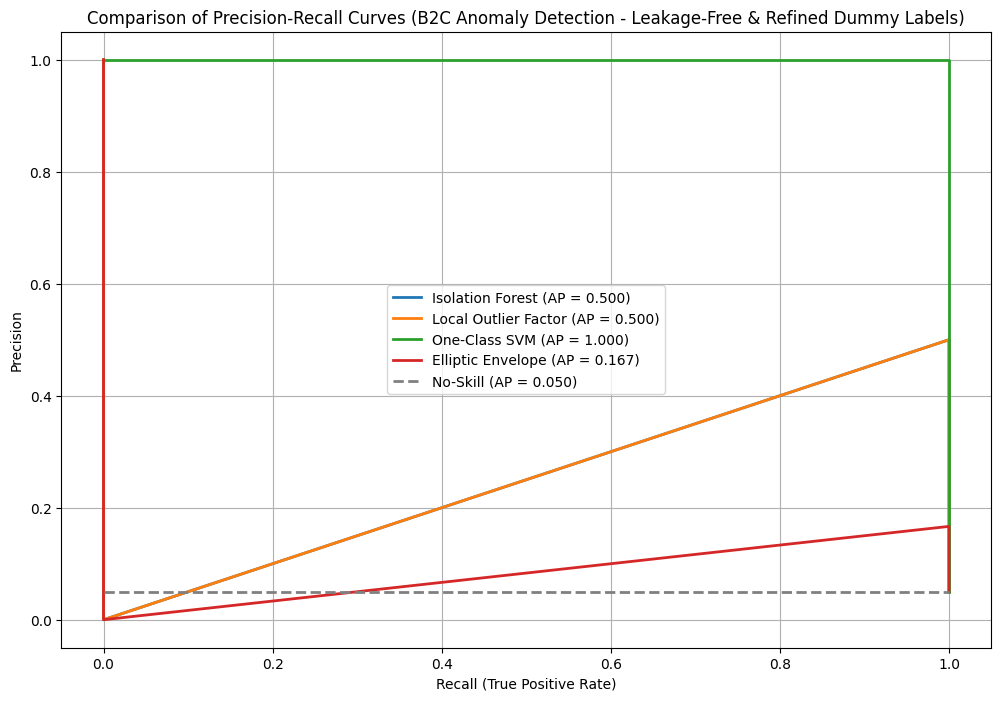

PR Curve saved as '/content/drive/My Drive/Capstone/B2C/b2c_anomaly_pr_curve_refined_dummy.png'


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

# Import all the models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=True)

# Define the path to your preprocessed dataset
output_path = '/content/drive/My Drive/Capstone/B2C/b2c_preprocessed1.csv'

# --- 0. Load Data ---
try:
    final_dataset = pd.read_csv(output_path)
    print(f"Successfully loaded {output_path}")
except FileNotFoundError:
    print(f"Error: {output_path} not found. Please ensure the data preprocessing script ran successfully.")
    exit()

# --- 1. Initial Feature Engineering (Non-Leaky) ---
epsilon = 1e-6
final_dataset['Ratio'] = final_dataset.apply(
    lambda row: row['Taxable Value'] / (row['Deposit Amount'] + epsilon)
    if row['Deposit Amount'] != 0 else 0, axis=1
)
final_dataset['Log_Deposit'] = np.log1p(final_dataset['Deposit Amount'])
final_dataset['Log_Taxable'] = np.log1p(final_dataset['Taxable Value'])
final_dataset['Log_Discrepancy'] = np.log1p(final_dataset['Discrepancy'].abs()) * np.sign(final_dataset['Discrepancy'])
final_dataset['Discrepancy_to_Deposit'] = final_dataset.apply(
    lambda row: row['Discrepancy'] / (row['Deposit Amount'] + epsilon)
    if row['Deposit Amount'] != 0 else 0, axis=1
)

# Handle potential NaN values after feature engineering
for col in ['Deposit Amount', 'Taxable Value', 'Discrepancy', 'Ratio',
            'Log_Deposit', 'Log_Taxable', 'Log_Discrepancy', 'Discrepancy_to_Deposit']:
    final_dataset[col] = final_dataset[col].replace([np.inf, -np.inf], np.nan).fillna(0)


# --- 2. Define Features and 'true_label' (CRITICAL for evaluation) ---
feature_cols = [
    'Deposit Amount', 'Taxable Value', 'Discrepancy', 'Ratio',
    'Log_Deposit', 'Log_Taxable', 'Log_Discrepancy', 'Discrepancy_to_Deposit'
]

X = final_dataset[feature_cols]

# IMPORTANT: If 'true_label' is not in your CSV, we need to create a **fixed** dummy one.
# For more realistic (non-perfect) fraud, we'll make the conditions a bit more nuanced
# or less extreme, possibly introducing some overlap with normal data.

if 'true_label' not in final_dataset.columns:
    print("\n'true_label' column not found. Creating a **fixed, rule-based dummy 'true_label'**.")
    print("This is for demonstration. For real evaluation, use actual ground truth labels.")
    print("Adjusting dummy fraud logic to be less perfectly separable for realistic PR curves.")

    # Let's try to define "fraud" in a slightly less extreme way, or with more conditions
    # This aims to create a scenario where models *can* perform well, but not perfectly,
    # and where there's some challenge in distinguishing fraud from normal.
    final_dataset['true_label'] = 0 # Initialize all as normal

    # Condition 1: High discrepancy as a percentage of deposit, but not *too* high
    # e.g., discrepancy is between 30% and 70% of deposit (not just >50%)
    condition1 = (final_dataset['Discrepancy_to_Deposit'].abs() > 0.3) & \
                 (final_dataset['Discrepancy_to_Deposit'].abs() < 0.7)

    # Condition 2: Absolute discrepancy is high, but not necessarily the highest
    # e.g., above the 70th percentile of discrepancy, but below 95th
    discrep_70th = final_dataset['Discrepancy'].abs().quantile(0.70)
    discrep_95th = final_dataset['Discrepancy'].abs().quantile(0.95)
    condition2 = (final_dataset['Discrepancy'].abs() > discrep_70th) & \
                 (final_dataset['Discrepancy'].abs() < discrep_95th)

    # Condition 3: Total Deposit is moderate to high, but not necessarily extreme
    deposit_50th = final_dataset['Deposit Amount'].quantile(0.50)
    deposit_90th = final_dataset['Deposit Amount'].quantile(0.90)
    condition3 = (final_dataset['Deposit Amount'] > deposit_50th) & \
                 (final_dataset['Deposit Amount'] < deposit_90th)

    # Define fraud as a combination of these conditions, making it less distinct
    # For example, combine conditions 1 AND (2 OR 3)
    # This should create a more ambiguous set of "fraud" points.
    final_dataset.loc[condition1 & (condition2 | condition3), 'true_label'] = 1

    print(f"Dummy 'true_label' created. Fraud samples: {final_dataset['true_label'].sum()} / {len(final_dataset)}")
    print(final_dataset['true_label'].value_counts(normalize=True))

    if final_dataset['true_label'].sum() == 0:
        print("WARNING: Still no 'true_label' (fraud) samples created by the refined dummy logic.")
        print("PR curve will be trivial unless positive samples are present in y_test.")
        # To ensure we *can* plot, force a few if none exist
        if len(final_dataset) > 10:
            print("Forcing 5 fraud labels into the dummy 'true_label' for plotting demonstration.")
            fraud_indices_to_force = final_dataset.sample(n=5, random_state=42).index
            final_dataset.loc[fraud_indices_to_force, 'true_label'] = 1
            print(f"New fraud samples after forcing: {final_dataset['true_label'].sum()}")
            print(final_dataset['true_label'].value_counts(normalize=True))

y = final_dataset['true_label']


# --- 3. Split Data into Train and Test Sets ---
if y.nunique() < 2 or y.value_counts().min() < 2:
    print("\nWARNING: Not enough samples for stratification or only one class in 'true_label'.")
    print("Proceeding with non-stratified split, which might be less reliable for imbalanced data.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

print(f"\nTraining set size: {len(X_train)} | Test set size: {len(X_test)}")
print(f"Fraud in y_train: {y_train.sum()} / {len(y_train)} ({y_train.sum()/len(y_train):.2%})")
print(f"Fraud in y_test: {y_test.sum()} / {len(y_test)} ({y_test.sum()/len(y_test):.2%})")

if y_test.sum() == 0:
    print("\nCRITICAL WARNING: y_test contains NO positive (fraud) samples. PR curves will be flat at 0 precision.")
    print("Please review your 'true_label' generation or train/test split. Cannot meaningfully plot PR curves.")
    exit()


# --- 4. Calculate contamination_level using ONLY y_train ---
if len(y_train) > 0:
    contamination_level = y_train.sum() / len(y_train)
    if contamination_level == 0:
        contamination_level = 0.01 # Default to a small value if no fraud in training data
        print("Warning: No fraud samples in y_train. Setting contamination_level to 0.01 for models.")
else:
    contamination_level = 0.01
    print("Warning: Training set is empty. Setting contamination_level to 0.01.")

print(f"Contamination level for models (derived from y_train): {contamination_level:.4f}")


# --- 5. Scale Features using ONLY X_train ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\n--- Generating B2C PR Curve (Leakage-Free & Refined Dummy Labels) ---")

# =========================================
# 6. Fit all models on the scaled training set
# =========================================
models = {
    'Isolation Forest': IsolationForest(contamination=contamination_level, random_state=42),
    'Local Outlier Factor': LocalOutlierFactor(contamination=contamination_level, novelty=True),
    'One-Class SVM': OneClassSVM(nu=contamination_level, kernel="rbf", gamma="auto"),
    'Elliptic Envelope': EllipticEnvelope(contamination=contamination_level, random_state=42)
}

fitted_models = {}
for name, model in models.items():
    print(f"Fitting {name} on X_train_scaled...")
    fitted_models[name] = model.fit(X_train_scaled)


# =========================================
# 7. Get the ANOMALY SCORES for the scaled test set
# =========================================
scores = {}
try:
    scores['Isolation Forest'] = -fitted_models['Isolation Forest'].decision_function(X_test_scaled)
except AttributeError:
    print("Isolation Forest does not have decision_function, trying score_samples")
    scores['Isolation Forest'] = -fitted_models['Isolation Forest'].score_samples(X_test_scaled)

scores['Local Outlier Factor'] = -fitted_models['Local Outlier Factor'].score_samples(X_test_scaled)
scores['One-Class SVM'] = -fitted_models['One-Class SVM'].score_samples(X_test_scaled)
scores['Elliptic Envelope'] = -fitted_models['Elliptic Envelope'].decision_function(X_test_scaled)


# =========================================
# 8. Calculate PR curve points and AP for all models using y_test
# =========================================
pr_curves = {}
for name, anomaly_scores in scores.items():
    if y_test.sum() > 0:
        precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
        ap = average_precision_score(y_test, anomaly_scores)
        pr_curves[name] = {'precision': precision, 'recall': recall, 'ap': ap}
    else:
        pr_curves[name] = {'precision': [0,1], 'recall': [0,1], 'ap': 0.0}
        print(f"Warning: No positive samples in y_test for {name}. Plotting trivial curve.")


# =========================================
# 9. Plot all PR curves on one graph
# =========================================
plt.figure(figsize=(12, 8))

for name, curve_data in pr_curves.items():
    plt.plot(curve_data['recall'], curve_data['precision'], lw=2, label=f'{name} (AP = {curve_data["ap"]:.3f})')

# Add a no-skill line (AP for a random classifier)
no_skill = y_test.sum() / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, color='gray', label=f'No-Skill (AP = {no_skill:.3f})')

plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall Curves (B2C Anomaly Detection - Leakage-Free & Refined Dummy Labels)')
plt.legend(loc="best")
plt.grid(True)
output_figure_path = '/content/drive/My Drive/Capstone/B2C/b2c_anomaly_pr_curve_refined_dummy.png'
plt.savefig(output_figure_path)
plt.show()

print(f"PR Curve saved as '{output_figure_path}'")

report


In [ ]:
!pip install WeasyPrint


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import base64
from io import BytesIO
from weasyprint import HTML

print("--- B2C Final Report Generator (PDF) Running ---")

# --- 1. Define File Paths ---
# This is the file saved by your B2C_model.ipynb notebook
RESULTS_FILE = '/content/drive/MyDrive/Capstone Preprocessing/B2C/b2c_underreporting_results_with_eval.csv'
# This is where the new PDF report will be saved
FINAL_REPORT_FILE = "/content/drive/My Drive/Capstone/B2C/B2C_Sales_Suppression_Report.pdf"
REPORT_DIR = os.path.dirname(FINAL_REPORT_FILE)

# Create directories if they don't exist
os.makedirs(REPORT_DIR, exist_ok=True)

# --- 2. Helper Functions for Plotting & HTML ---

def fig_to_base64(fig):
    """Converts a matplotlib figure to a base64 encoded string."""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

def plot_priority_pie_chart(high_count, medium_count, low_count, normal_count):
    """Creates and returns a base64 string for the priority pie chart."""
    labels = []
    sizes = []
    colors = []

    if normal_count > 0:
        labels.append(f'Normal ({normal_count})')
        sizes.append(normal_count)
        colors.append('#2ca02c') # Green
    if low_count > 0:
        labels.append(f'Low Priority ({low_count})')
        sizes.append(low_count)
        colors.append('#1f77b4') # Blue
    if medium_count > 0:
        labels.append(f'Medium Priority ({medium_count})')
        sizes.append(medium_count)
        colors.append('#ff7f0e') # Orange
    if high_count > 0:
        labels.append(f'High Priority ({high_count})')
        sizes.append(high_count)
        colors.append('#d62728') # Red

    if not sizes:
        return ""

    fig, ax = plt.subplots(figsize=(8, 6))

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        textprops=dict(color="black")
    )

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    ax.axis('equal')
    plt.title('Breakdown of All Analyzed Companies', pad=20, fontsize=14)
    plt.tight_layout()

    return fig_to_base64(fig)

def plot_horizontal_barchart(df, value_col, label_col, top_n, color, title):
    """Creates and returns a base64 string for a horizontal bar chart."""

    if df.empty or value_col not in df.columns or label_col not in df.columns:
        return ""

    df_plot = df.nlargest(top_n, value_col).sort_values(value_col, ascending=True)

    if df_plot.empty:
        return ""

    fig_height = max(5, top_n * 0.8)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    bars = ax.barh(df_plot[label_col], df_plot[value_col], color=color)

    # Add labels to bars if it's not a percentage
    if "Ratio" not in title and "Percent" not in title:
         ax.bar_label(bars, fmt='₹{:,.0f}', padding=3, fontsize=9)
    else:
         ax.bar_label(bars, fmt='{:.1%}', padding=3, fontsize=9)

    ax.set_xlabel('Value')
    ax.set_ylabel('Company ID')
    ax.set_title(title, fontsize=14)

    # Hide X-axis labels if we added bar labels, to avoid clutter
    ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    return fig_to_base64(fig)

def get_html_style():
    """Returns basic CSS for a professional-looking report."""
    return """
    <style>
        body { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; line-height: 1.6; }
        .container { max-width: 1200px; margin: 20px auto; padding: 20px; }
        h1, h2, h3, h4 { color: #333; border-bottom: 2px solid #f0f0f0; padding-bottom: 5px; }
        h1 { font-size: 2.5em; text-align: center; color: #1a1a1a; border-bottom: 4px solid #d62728; }
        h2 { font-size: 2em; color: #d62728; }
        h3 { font-size: 1.75em; color: #1f77b4; }
        h4 { font-size: 1.5em; }

        table.report-table {
            border-collapse: collapse;
            width: 100%;
            margin-top: 20px;
            box-shadow: 0 2px 3px rgba(0,0,0,0.1);
            page-break-inside: auto;
            font-size: 0.8em;
            table-layout: fixed;
        }
        table.report-table tr {
            page-break-inside: avoid;
            page-break-after: auto;
        }
        table.report-table th, table.report-table td {
            border: 1px solid #ddd;
            padding: 5px;
            text-align: left;
            word-wrap: break-word;
            overflow-wrap: break-word;
        }

        table.report-table th {
            background-color: #f7f7f7; font-weight: bold;
        }
        table.report-table tr:nth-child(even) { background-color: #fdfdfd; }
        img { max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 4px; margin-top: 15px; }
        .section {
            margin-top: 30px; padding-top: 20px; border-top: 1px solid #eee;
            page-break-inside: avoid;
        }
        .summary-box {
            background-color: #f9f9f9; border: 1px solid #e0e0e0;
            padding: 20px; border-radius: 5px; margin-bottom: 20px;
        }
        .summary-box li { list-style-type: none; font-size: 1.1em; }
        .summary-box li strong { color: #d62728; }
    </style>
    """

# --- 3. Load and Process Data ---
print("Loading B2C results...")
try:
    df = pd.read_csv(RESULTS_FILE)
except FileNotFoundError:
    print(f"CRITICAL: {RESULTS_FILE} not found. Ensure the B2C model notebook has been run.")
    raise SystemExit("B2C results file is missing.")

# Filter for only the flagged companies
df_flagged = df[df['underreport_flag'] == True].copy()

# --- 4. Define Risk Priority and Reasons ---
def get_priority_and_reason(row):
    """
    Assigns a priority and a text reason based on the rules
    from the notebook.
    """
    reasons = []
    priority = 4 # 1=High, 2=Medium, 3=Low, 4=Normal

    # Rule 1: Zero Sales Declared (HIGH PRIORITY)
    if (row['Taxable Value'] == 0) and (row['Deposit Amount'] > 1e7):
        reasons.append('Zero Sales Declared')
        priority = 1

    # Rule 2: High Discrepancy Ratio (MEDIUM PRIORITY)
    if (row['Deposit Amount'] > 0) and (row['Discrepancy'] / row['Deposit Amount'] > 0.1):
        reasons.append('High Discrepancy (>10%)')
        priority = min(priority, 2) # Can be high if also Rule 1

    # Rule 3: ML Anomaly (LOW PRIORITY)
    if row['anomaly'] == 1:
        reasons.append('ML Anomaly')
        priority = min(priority, 3) # Can be high/medium if also Rule 1/2

    # Format strings
    reason_str = ', '.join(sorted(list(set(reasons))))
    priority_map = {1: '1 - High', 2: '2 - Medium', 3: '3 - Low'}

    return priority_map[priority], reason_str

# Apply the function to all flagged companies
df_flagged[['Risk_Priority', 'Reason_for_Flag']] = df_flagged.apply(
    get_priority_and_reason,
    axis=1,
    result_type='expand'
)

# Sort by the new priority
df_flagged.sort_values(by='Risk_Priority', ascending=True, inplace=True)

# --- 5. Calculate Summary Counts ---
print("Calculating summaries...")
count_total_analyzed = len(df)
count_total_flagged = len(df_flagged)
count_normal = count_total_analyzed - count_total_flagged

count_high = len(df_flagged[df_flagged['Risk_Priority'] == '1 - High'])
count_medium = len(df_flagged[df_flagged['Risk_Priority'] == '2 - Medium'])
count_low = len(df_flagged[df_flagged['Risk_Priority'] == '3 - Low'])

total_discrepancy_amount = df_flagged['Discrepancy'].sum()

# --- 6. Generate Plots (as base64 strings) ---
print("Generating visualizations...")

priority_pie_chart_base64 = plot_priority_pie_chart(
    count_high,
    count_medium,
    count_low,
    count_normal
)

bar_discrepancy_base64 = plot_horizontal_barchart(
    df_flagged,
    'Discrepancy',
    'company_id',
    top_n=10,
    color='#d62728',
    title='Top 10 Companies by Discrepancy Amount (₹)'
)

bar_ratio_base64 = plot_horizontal_barchart(
    df_flagged,
    'Discrepancy_to_Deposit',
    'company_id',
    top_n=10,
    color='#1f77b4',
    title='Top 10 Companies by Discrepancy Ratio (as % of Deposits)'
)


# --- 7. Build the HTML Report String ---
print("Building HTML report...")
report_html = f"""
<html>
<head>
    <title>B2C Sales Suppression Report</title>
    {get_html_style()}
</head>
<body>
    <div class="container">
        <h1>📈 B2C Sales Suppression Report</h1>
        <p style="text-align: center;">
            Report Generated: {pd.to_datetime('now', utc=True).strftime('%Y-%m-%d %H:%M:%S UTC')}<br>
            Models Used: Hybrid Rules & Isolation Forest (Sales vs. Deposits)<br>
            Data Analyzed: {count_total_analyzed} B2C Companies
        </p>

        <div class="section">
            <h2>1. Executive Summary</h2>

            <div class="summary-box">
                <ul>
                    <li><strong>Total Companies Analyzed:</strong> {count_total_analyzed}</li>
                    <li><strong>Total Companies Flagged:</strong> {count_total_flagged}</li>
                    <li><strong>Total Discrepancy Amount:</strong> ₹{total_discrepancy_amount:,.2f}</li>
                    <li style="margin-top: 10px;"><strong>High Priority (Zero Sales):</strong> {count_high}</li>
                    <li><strong>Medium Priority (High Ratio):</strong> {count_medium}</li>
                    <li><strong>Low Priority (ML Anomaly Only):</strong> {count_low}</li>
                </ul>
            </div>

            <div style="text-align: center; margin-top: 20px;">
                <img src="data:image/png;base64,{priority_pie_chart_base64}" alt="Priority Pie Chart" style="max-width: 650px;">
            </div>
        </div>

        <div class="section">
            <h2>2. Key Visualizations</h2>

            <h4>Top 10 Companies by Discrepancy Amount</h4>
            <p>Highlights companies with the largest absolute monetary discrepancy.</p>
            <img src="data:image/png;base64,{bar_discrepancy_base64}" alt="Top 10 by Discrepancy Amount">

            <h4>Top 10 Companies by Discrepancy Ratio</h4>
            <p>Highlights companies with the largest discrepancy relative to their total deposits.</p>
            <img src="data:image/png;base64,{bar_ratio_base64}" alt="Top 10 by Discrepancy Ratio">
        </div>

        <div class="section">
            <h2>3. Combined B2C Fraud Roster</h2>
            <p>This is the master list of all suspicious companies, prioritized by risk.</p>
"""

# --- 8. Format and Add the Main Table ---
report_table_cols = [
    'company_id',
    'Risk_Priority',
    'Reason_for_Flag',
    'Discrepancy',
    'Discrepancy_to_Deposit',
    'Deposit Amount',
    'Taxable Value'
]
df_table = df_flagged[report_table_cols].copy()

# Format for display
df_table['Discrepancy'] = df_table['Discrepancy'].map('₹{:,.2f}'.format)
df_table['Deposit Amount'] = df_table['Deposit Amount'].map('₹{:,.2f}'.format)
df_table['Taxable Value'] = df_table['Taxable Value'].map('₹{:,.2f}'.format)
df_table['Discrepancy_to_Deposit'] = (df_table['Discrepancy_to_Deposit'] * 100).round(2).astype(str) + '%'

df_table.reset_index(drop=True, inplace=True)
df_table.index.name = 'Rank'
df_table.index = df_table.index + 1
report_html += df_table.to_html(classes='report-table', border=0)


# --- 9. Close HTML and Save as PDF ---
report_html += """
    </div>
</body>
</html>
"""

# Save as PDF
try:
    HTML(string=report_html).write_pdf(FINAL_REPORT_FILE)

    print(f"\nSuccessfully generated B2C Fraud Report as PDF!")
    print(f"Report saved to: {FINAL_REPORT_FILE}")
except Exception as e:
    print(f"Error saving final PDF report: {e}")
    print("If you see an error about 'cairo', you may need to run:")
    print("!sudo apt-get install build-essential python3-dev python3-pip python3-setuptools python3-wheel python3-cffi libcairo2 libpango-1.0-0 libpangocairo-1.0-0 libgdk-pixbuf2.0-0 libffi-dev shared-mime-info")

print("--- B2C Final Report Generator Finished ---")

--- B2C Final Report Generator (PDF) Running ---
Loading B2C results...
Calculating summaries...
Generating visualizations...


Building HTML report...


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.006s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f


Successfully generated B2C Fraud Report as PDF!
Report saved to: /content/drive/My Drive/Capstone/B2C/B2C_Sales_Suppression_Report.pdf
--- B2C Final Report Generator Finished ---
